In [25]:
import numpy as np
import pandas as pd
import seaborn as sns
import fortitudo.tech as ft
import matplotlib.pyplot as plt

In [26]:
ep_data = pd.read_csv('EP.csv')

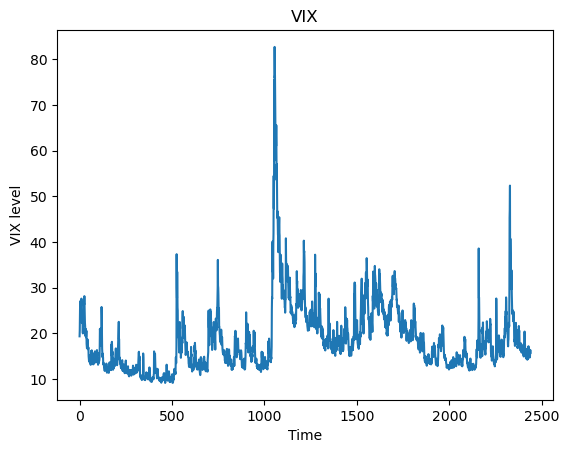

In [27]:
imp_vol_1m = ep_data['VIX'].values

plt.plot(imp_vol_1m)
plt.title('VIX')
plt.ylabel('VIX level')
plt.xlabel('Time')
plt.show()

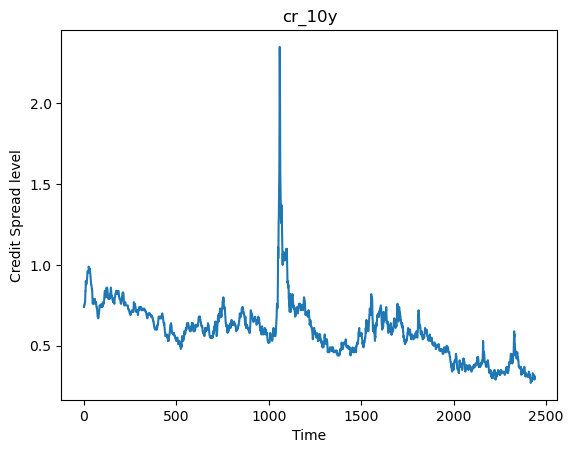

In [37]:
cr_10y = ep_data['cr_10y'].values

plt.plot(cr_10y)
plt.title('cr_10y')
plt.ylabel('Credit Spread level')
plt.xlabel('Time')
plt.show()

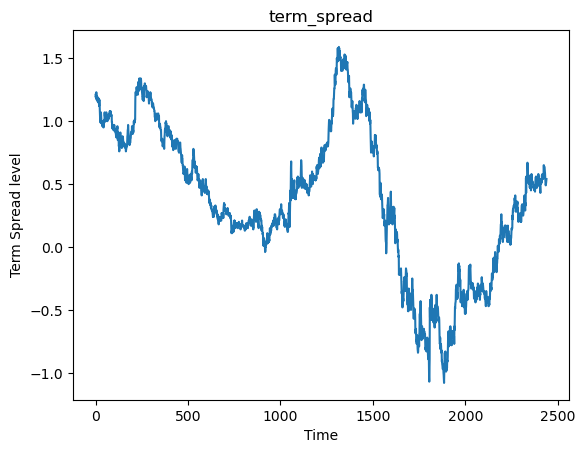

In [38]:
term_spread = ep_data['DGS10'].values - ep_data['DGS2'].values

plt.plot(term_spread)
plt.title('term_spread')
plt.ylabel('Term Spread level')
plt.xlabel('Time')
plt.show()

In [39]:
# VIX states (3 states)
imp_vol_25pct = np.percentile(imp_vol_1m, 25)
low_vol_indices = imp_vol_1m <= imp_vol_25pct
imp_vol_75pct = np.percentile(imp_vol_1m, 75)
mid_vol_indices = (imp_vol_1m > imp_vol_25pct) & (imp_vol_1m <= imp_vol_75pct)
high_vol_indices = imp_vol_1m > imp_vol_75pct

# Credit spread states (3 states)
cr_narrow_indices = cr_10y < 0.5
cr_normal_indices = (cr_10y >= 0.5) & (cr_10y < 1.0)
cr_wide_indices = cr_10y >= 1.0

# Term spread states (2 states)
ts_inverted_indices = term_spread < 0
ts_normal_indices = term_spread >= 0

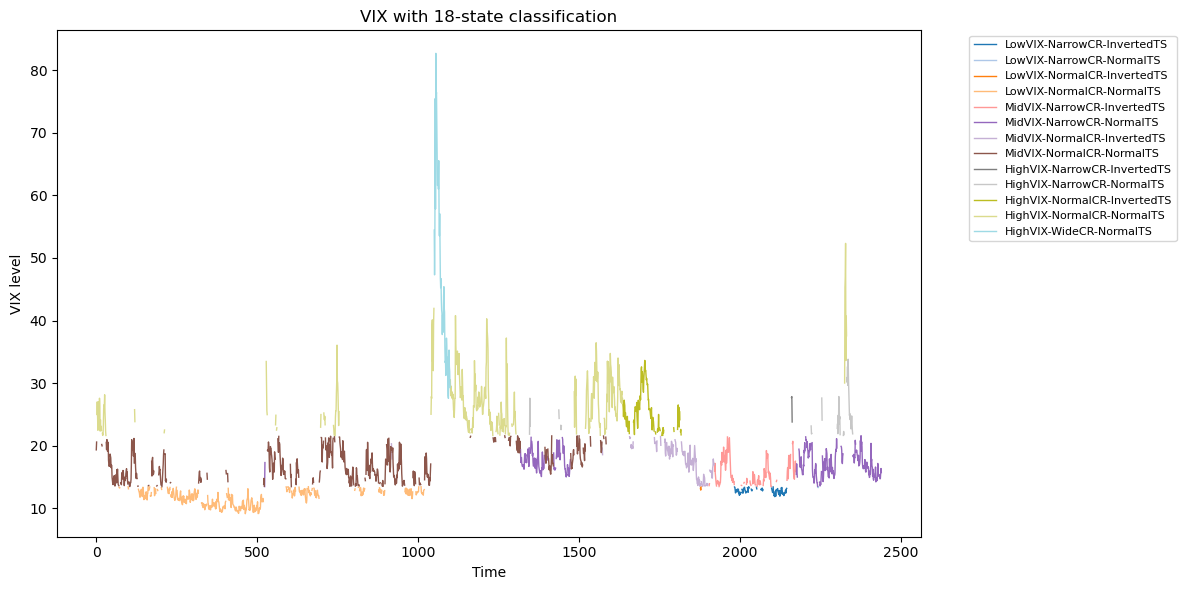

In [40]:
# Create combined state classification and map onto VIX
# States: VIX (3) × Credit (3) × Term (2) = 18 states
state_labels = []
state_colors = []

fig, ax = plt.subplots(figsize=(12, 6))

# Define all 18 combinations
vix_states = [('Low', low_vol_indices), ('Mid', mid_vol_indices), ('High', high_vol_indices)]
cr_states = [('Narrow', cr_narrow_indices), ('Normal', cr_normal_indices), ('Wide', cr_wide_indices)]
ts_states = [('Inverted', ts_inverted_indices), ('Normal', ts_normal_indices)]

colors = plt.cm.tab20(np.linspace(0, 1, 18))
color_idx = 0

x = np.arange(0, len(imp_vol_1m))

for vix_name, vix_idx in vix_states:
    for cr_name, cr_idx in cr_states:
        for ts_name, ts_idx in ts_states:
            # Combined state
            combined_state = vix_idx & cr_idx & ts_idx
            if combined_state.sum() > 0:  # Only plot if state exists
                vix_masked = np.ma.masked_where(combined_state == False, imp_vol_1m)
                label = f"{vix_name}VIX-{cr_name}CR-{ts_name}TS"
                ax.plot(x, vix_masked, color=colors[color_idx], label=label, linewidth=1)
            color_idx += 1

ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
ax.set_title('VIX with 18-state classification')
ax.set_xlabel('Time')
ax.set_ylabel('VIX level')
plt.tight_layout()
plt.show()

In [41]:
# Use your log returns as the stationary data
st_df = ep_data[['log_ret']].copy()

# Exponential decay prior
T_tilde = len(st_df)
p_exp = ft.exp_decay_probs(st_df, half_life=T_tilde / 2)

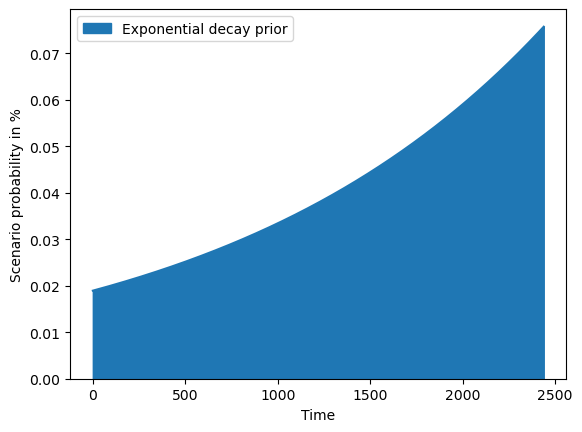

In [42]:
pd.DataFrame(100 * p_exp, columns=['Exponential decay prior']).plot(kind='area')
plt.ylabel('Scenario probability in %')
plt.xlabel('Time')
plt.show()

In [43]:
# Compute view values for Entropy Pooling views (18 states)
mu_states = []
sigma_states = []

for vix_idx in [low_vol_indices, mid_vol_indices, high_vol_indices]:
    for cr_idx in [cr_narrow_indices, cr_normal_indices, cr_wide_indices]:
        for ts_idx in [ts_inverted_indices, ts_normal_indices]:
            # Combined state
            combined_state = vix_idx & cr_idx & ts_idx
            
            if combined_state.sum() > 0:  # Make sure state has observations
                mu_states.append(np.mean(imp_vol_1m[combined_state]))
                sigma_states.append(np.std(imp_vol_1m[combined_state]))
            else:
                # If no observations, use overall mean/std
                mu_states.append(np.mean(imp_vol_1m))
                sigma_states.append(np.std(imp_vol_1m))

# Convert to arrays for easier indexing
mu_states = np.array(mu_states)
sigma_states = np.array(sigma_states)

print(f"Number of states: {len(mu_states)}")

Number of states: 18


In [44]:
# Specify left hand sides for Entropy Pooling views (18 states)
A = np.vstack((np.ones((1, T_tilde)), imp_vol_1m))  # probabilities sum to 1 and mean
G = imp_vol_1m[:, np.newaxis].T ** 2

# Create b and h for all 18 states
b_states = []
h_states = []

for i in range(len(mu_states)):
    b_states.append(np.array([[1.], [mu_states[i]]]))
    h_states.append(np.array([[sigma_states[i] ** 2 + mu_states[i] ** 2]]))

In [45]:
# Compute Fully Flexible Resampling probability vectors (18 states)
q_states = []

for i in range(len(mu_states)):
    q_states.append(ft.entropy_pooling(p_exp, A, b_states[i], G, h_states[i]))

# Convert to array for easier manipulation
q_states = np.array(q_states)

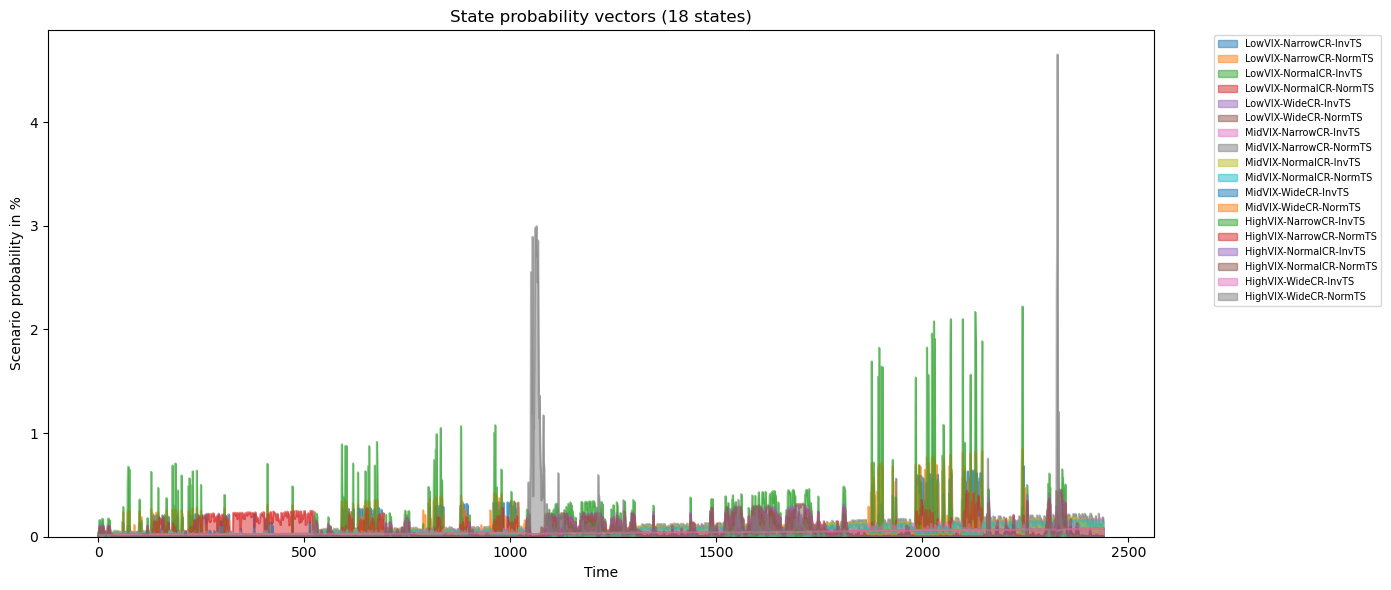

In [46]:
# Normalize and stack all 18 state probabilities
states_prob = np.hstack([q_states[i] / np.sum(q_states[i]) for i in range(len(q_states))])

# Create column names for all 18 states
state_names = []
for vix_name in ['LowVIX', 'MidVIX', 'HighVIX']:
    for cr_name in ['NarrowCR', 'NormalCR', 'WideCR']:
        for ts_name in ['InvTS', 'NormTS']:
            state_names.append(f"{vix_name}-{cr_name}-{ts_name}")

# Plot state probabilities
pd.DataFrame(100 * states_prob, columns=state_names).plot(kind='area', stacked=False, figsize=(14, 6))
plt.title('State probability vectors (18 states)')
plt.xlabel('Time')
plt.ylabel('Scenario probability in %')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=7)
plt.tight_layout()
plt.show()

In [47]:
# Create states_vector for all 18 states (0 to 17)
states_vector = np.zeros(len(imp_vol_1m), dtype=int)

state_idx = 0
for vix_idx in [low_vol_indices, mid_vol_indices, high_vol_indices]:
    for cr_idx in [cr_narrow_indices, cr_normal_indices, cr_wide_indices]:
        for ts_idx in [ts_inverted_indices, ts_normal_indices]:
            # Combined state
            combined_state = vix_idx & cr_idx & ts_idx
            states_vector[combined_state] = state_idx
            state_idx += 1

# Check state distribution
print(f"State distribution:")
for i in range(18):
    count = np.sum(states_vector == i)
    print(f"State {i} ({state_names[i]}): {count} observations")

State distribution:
State 0 (LowVIX-NarrowCR-InvTS): 102 observations
State 1 (LowVIX-NarrowCR-NormTS): 4 observations
State 2 (LowVIX-NormalCR-InvTS): 7 observations
State 3 (LowVIX-NormalCR-NormTS): 499 observations
State 4 (LowVIX-WideCR-InvTS): 0 observations
State 5 (LowVIX-WideCR-NormTS): 0 observations
State 6 (MidVIX-NarrowCR-InvTS): 152 observations
State 7 (MidVIX-NarrowCR-NormTS): 334 observations
State 8 (MidVIX-NormalCR-InvTS): 160 observations
State 9 (MidVIX-NormalCR-NormTS): 572 observations
State 10 (MidVIX-WideCR-InvTS): 0 observations
State 11 (MidVIX-WideCR-NormTS): 0 observations
State 12 (HighVIX-NarrowCR-InvTS): 4 observations
State 13 (HighVIX-NarrowCR-NormTS): 55 observations
State 14 (HighVIX-NormalCR-InvTS): 121 observations
State 15 (HighVIX-NormalCR-NormTS): 380 observations
State 16 (HighVIX-WideCR-InvTS): 0 observations
State 17 (HighVIX-WideCR-NormTS): 50 observations


In [48]:
# Define a Fully Flexible Resampling function
def resampling(S, H, initial_state, states_prob, states_vector):
    sim = np.full((S, H), 1)
    t = np.arange(len(states_vector))
    for s in range(S):
        current_state = initial_state
        for h in range(H):
            sim[s, h] = np.random.choice(t, p=states_prob[:, current_state])
            current_state = states_vector[sim[s, h]]
    return sim

In [49]:
# Simulate historical observations
S = 10000
H = 21
np.random.seed(0)
sim = resampling(S, H, states_vector[-1], states_prob, states_vector)

In [50]:
# Extract stationary transformations and compute cumulative sums
N_tilde = st_df.shape[1]
st_sim = np.full((S, N_tilde, H), np.nan)
for s in range(S):
    st_sim[s, :, :] = st_df.values[sim[s, :], :].T
st_sim_cumsum = np.cumsum(st_sim, axis=2)

In [51]:
print(f'The stationary transformations simulation dimension is {st_sim.shape}')

The stationary transformations simulation dimension is (10000, 1, 21)


/Users/galamboslajos/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


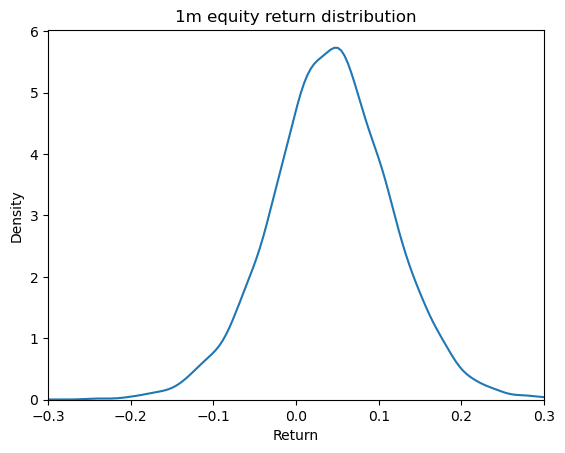

In [52]:
import seaborn as sns

# Equity returns
equity_returns = np.exp(st_sim_cumsum[:, 0, -1]) - 1
sns.kdeplot(equity_returns)
plt.title('1m equity return distribution')
plt.xlabel('Return')
plt.xlim([-0.3, 0.3])
plt.show()

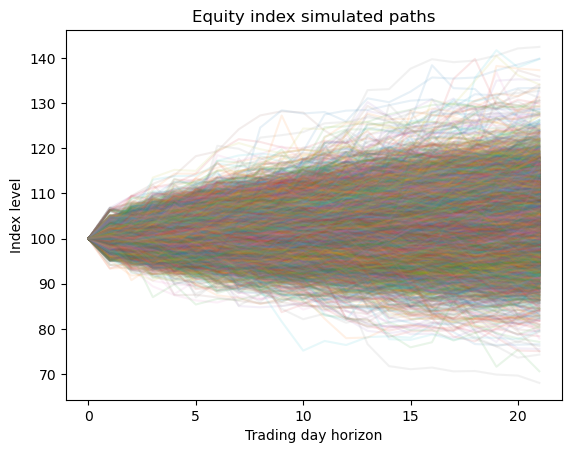

In [53]:
# Equity paths
init_val = 100  # Starting index level
equity_paths = np.concatenate((np.full((S, 1), init_val),
                               init_val * np.exp(st_sim_cumsum[:, 0, :])), axis=1)
plt.plot(equity_paths.T, alpha=0.1)
plt.title('Equity index simulated paths')
plt.ylabel('Index level')
plt.xlabel('Trading day horizon')
plt.show()

/Users/galamboslajos/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/galamboslajos/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/galamboslajos/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/galamboslajos/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be rem

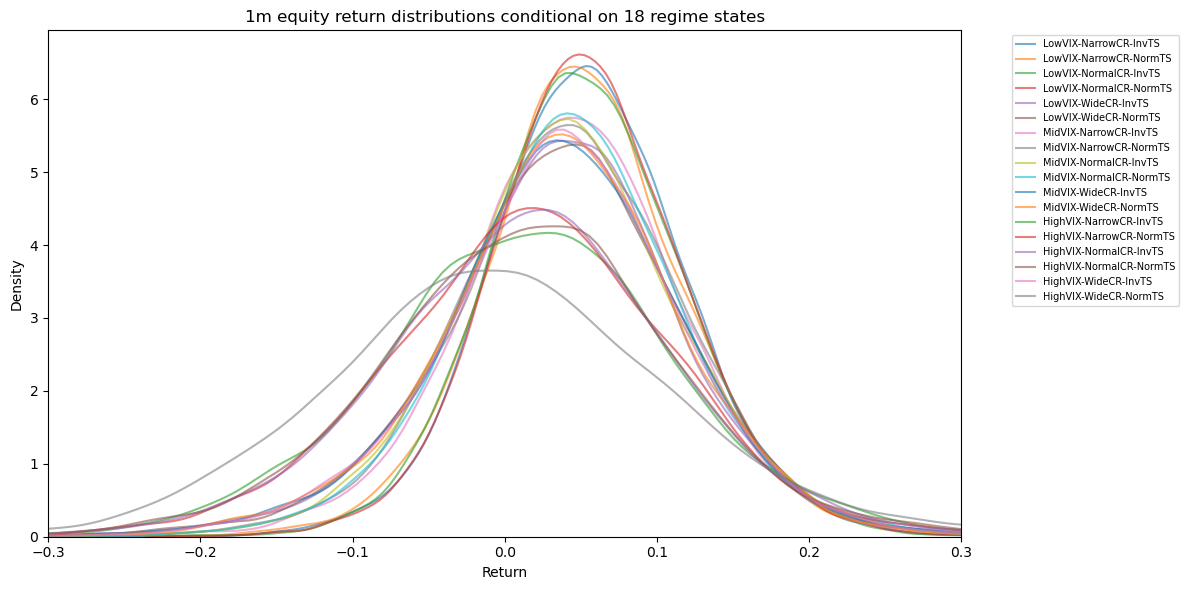

In [54]:
# Simulate historical observations by scenario (all 18 states)
S = 10000
H = 21
np.random.seed(0)

# Simulate starting from each of the 18 states
sim_by_state = []
equity_by_state = []
return_by_state = []

for state in range(18):
    sim = resampling(S, H, state, states_prob, states_vector)
    sim_by_state.append(sim)
    
    equity = np.full((S, H), np.nan)
    for s in range(S):
        equity[s, :] = st_df.values[sim[s, :], 0]
    equity_by_state.append(equity)
    
    returns = np.exp(np.cumsum(equity, axis=1)) - 1
    return_by_state.append(returns)

# Plot return distributions for all 18 states
plt.figure(figsize=(12, 6))
for state in range(18):
    sns.kdeplot(return_by_state[state][:, -1], label=state_names[state], alpha=0.6)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=7)
plt.title('1m equity return distributions conditional on 18 regime states')
plt.xlabel('Return')
plt.xlim([-0.3, 0.3])
plt.tight_layout()
plt.show()

In [55]:

transition_matrix = np.full((num_states, num_states), np.nan)
states = np.unique(states_vector)
for row_state in states:
    for col_state in states:
        transition_matrix[row_state, col_state] = np.sum(states_prob[states_vector == col_state, row_state])num_states = states_prob.shape[1]

In [56]:
# Print results
np.round(transition_matrix, 3)

array([[0.45 , 0.014, 0.019, 0.468,   nan,   nan, 0.016, 0.005, 0.01 ,
        0.018,   nan,   nan, 0.   , 0.   , 0.   , 0.   ,   nan, 0.   ],
       [0.379, 0.027, 0.044, 0.329,   nan,   nan, 0.074, 0.022, 0.046,
        0.08 ,   nan,   nan, 0.   , 0.   , 0.   , 0.   ,   nan, 0.   ],
       [0.442, 0.048, 0.081, 0.376,   nan,   nan, 0.017, 0.007, 0.01 ,
        0.019,   nan,   nan, 0.   , 0.   , 0.   , 0.   ,   nan, 0.   ],
       [0.199, 0.005, 0.006, 0.742,   nan,   nan, 0.017, 0.006, 0.008,
        0.017,   nan,   nan, 0.   , 0.   , 0.   , 0.   ,   nan, 0.   ],
       [  nan,   nan,   nan,   nan,   nan,   nan,   nan,   nan,   nan,
          nan,   nan,   nan,   nan,   nan,   nan,   nan,   nan,   nan],
       [  nan,   nan,   nan,   nan,   nan,   nan,   nan,   nan,   nan,
          nan,   nan,   nan,   nan,   nan,   nan,   nan,   nan,   nan],
       [0.056, 0.003, 0.005, 0.068,   nan,   nan, 0.16 , 0.344, 0.107,
        0.254,   nan,   nan, 0.   , 0.001, 0.001, 0.002,   nan, 0.   ],

In [58]:
# Calculate aggregate effective number of scenarios and relative entropy
q_total = np.mean(q_states, axis=0)  # Average across all 18 states

ens_total = np.exp(-np.sum(q_total * np.log(q_total)))
ens_pct_total = 100 * ens_total / T_tilde

re_total = np.sum(q_total * (np.log(q_total) - np.log(p_exp)))
re_pct_total = 100 * re_total / np.log(T_tilde)

print(f"Total Effective Number of Scenarios: {ens_pct_total:.2f}%")
print(f"Total Relative Entropy: {re_pct_total:.2f}%")

Total Effective Number of Scenarios: 84.06%
Total Relative Entropy: 1.40%
